# I. Import dependencies

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time

# II. Load data

In [2]:
X_train = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/X_train.csv", header=None)
y_train = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/y_train.csv", header=None)

X_test = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/X_test.csv", header=None)
y_test = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/y_test.csv", header=None)

# III. User-defined hyperparameters

In [3]:
X_train.shape, y_train.shape

((354, 13), (354, 1))

In [4]:
# D_in is input dimension; H is hidden dimension; D_out is output dimension.

batch_size, D_in, H, D_out = 16, 13, 100, 1
learning_rate = 1e-6
n_epochs = 1000

dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda")

# IV. Random weight initialization

In [5]:
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

# V. Perform training : CPU

In [6]:
def train(data, batch_size, model, n_epochs):
    
    X_train, y_train, X_test, y_test = data
    w1, w2 = model
    train_losses = []
    val_losses = []
    for t in range(n_epochs):

        epoch_start = time.time()
        train_loss = 0.
        val_loss = 0.  
        for state in ['train', 'val']:        

            batch_start_idx = 0
            n_samples = len(X_train) if state=='train' else len(X_test)        
            while batch_start_idx < n_samples:

                # Get next batch of data 
                batch_end_idx = batch_start_idx + batch_size
                if batch_end_idx > n_samples:  batch_end_idx = n_samples
                if state == 'train':  x, y = torch.Tensor(X_train.iloc[batch_start_idx:batch_end_idx, :].values), torch.Tensor(y_train.iloc[batch_start_idx:batch_end_idx, :].values)
                else:  x, y = torch.Tensor(X_test.iloc[batch_start_idx:batch_end_idx, :].values), torch.Tensor(y_test.iloc[batch_start_idx:batch_end_idx, :].values)

                # Forward pass: Compute output and loss
                h = x.mm(w1)
                h_relu = h.clamp(min=0)
                y_pred = h_relu.mm(w2)
                loss = (y_pred - y).pow(2).sum().item()
                if state == 'train':  train_loss += loss
                else:  val_loss += loss

                # Backward pass: Compute gradients
                if state == 'train':
                    grad_y_pred = 2.0 * (y_pred - y)
                    grad_w2 = h_relu.t().mm(grad_y_pred)
                    grad_h_relu = grad_y_pred.mm(w2.t())
                    grad_h = grad_h_relu.clone()
                    grad_h[h < 0] = 0
                    grad_w1 = x.t().mm(grad_h)

                # Update weights using gradient descent
                    w1 -= learning_rate * grad_w1
                    w2 -= learning_rate * grad_w2

                batch_start_idx = batch_end_idx

        # Print statistics
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        val_loss /= len(X_test)
        val_losses.append(val_loss)

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        print("Epoch ", (t+1), "/", n_epochs, " : Train-loss = ", train_loss, ", Val-loss = ", val_loss, ", Time for epoch = ", epoch_time, "s")

    # Plot loss-curves
    plt.figure()
    plt.plot(range(2, n_epochs+1), train_losses[1:], label='Train-loss')
    plt.plot(range(2, n_epochs+1), val_losses[1:], label='Val-loss')
    plt.title('Loss curves')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(linestyle='dotted')
    plt.show()

Epoch  1 / 1000  : Train-loss =  9628175673958.03 , Val-loss =  532.9839252672697 , Time for epoch =  0.024486303329467773 s
Epoch  2 / 1000  : Train-loss =  556.5368514411193 , Val-loss =  527.9073197214227 , Time for epoch =  0.014908552169799805 s
Epoch  3 / 1000  : Train-loss =  348.7886156847248 , Val-loss =  121.50880833675987 , Time for epoch =  0.013933420181274414 s
Epoch  4 / 1000  : Train-loss =  149.60300622282728 , Val-loss =  108.80851223594264 , Time for epoch =  0.014962196350097656 s
Epoch  5 / 1000  : Train-loss =  134.27879600740422 , Val-loss =  102.30001389352898 , Time for epoch =  0.013482093811035156 s
Epoch  6 / 1000  : Train-loss =  125.75166501837262 , Val-loss =  97.93124590421978 , Time for epoch =  0.013166189193725586 s
Epoch  7 / 1000  : Train-loss =  119.71328743972347 , Val-loss =  94.96819666812294 , Time for epoch =  0.012553930282592773 s
Epoch  8 / 1000  : Train-loss =  115.23233161538334 , Val-loss =  92.78923877916839 , Time for epoch =  0.012652

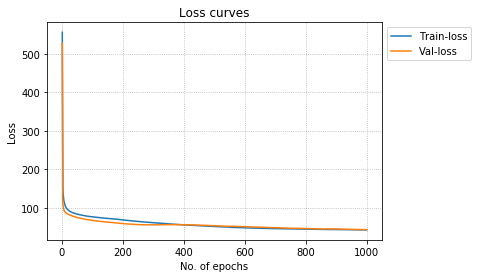

CPU times: user 15.5 s, sys: 296 ms, total: 15.8 s
Wall time: 15.3 s


In [7]:
%%time
train([X_train, y_train, X_test, y_test], batch_size, [w1, w2], n_epochs)

# VI. Perform training : GPU

In [6]:
def train(data, batch_size, model, n_epochs):
    
    X_train, y_train, X_test, y_test = data
    w1, w2 = model
    train_losses = []
    val_losses = []
    for t in range(n_epochs):

        epoch_start = time.time()
        train_loss = 0.
        val_loss = 0.    
        for state in ['train', 'val']:        

            batch_start_idx = 0
            n_samples = len(X_train) if state=='train' else len(X_test)        
            while batch_start_idx < n_samples:

                # Get next batch of data 
                batch_end_idx = batch_start_idx + batch_size
                if batch_end_idx > n_samples:  batch_end_idx = n_samples
                if state == 'train':  x, y = torch.Tensor(X_train.iloc[batch_start_idx:batch_end_idx, :].values).cuda(), torch.Tensor(y_train.iloc[batch_start_idx:batch_end_idx, :].values).cuda()
                else:  x, y = torch.Tensor(X_test.iloc[batch_start_idx:batch_end_idx, :].values).cuda(), torch.Tensor(y_test.iloc[batch_start_idx:batch_end_idx, :].values).cuda()

                # Forward pass: Compute output and loss
                h = x.mm(w1)
                h_relu = h.clamp(min=0)
                y_pred = h_relu.mm(w2)
                loss = (y_pred - y).pow(2).sum().item()
                if state == 'train':  train_loss += loss
                else:  val_loss += loss

                # Backward pass: Compute gradients
                if state == 'train':
                    grad_y_pred = 2.0 * (y_pred - y)
                    grad_w2 = h_relu.t().mm(grad_y_pred)
                    grad_h_relu = grad_y_pred.mm(w2.t())
                    grad_h = grad_h_relu.clone()
                    grad_h[h < 0] = 0
                    grad_w1 = x.t().mm(grad_h)

                # Update weights using gradient descent
                    w1 -= learning_rate * grad_w1
                    w2 -= learning_rate * grad_w2

                batch_start_idx = batch_end_idx

        # Print statistics
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        val_loss /= len(X_test)
        val_losses.append(val_loss)

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        print("Epoch ", (t+1), "/", n_epochs, " : Train-loss = ", train_loss, ", Val-loss = ", val_loss, ", Time for epoch = ", epoch_time, "s")

    # Plot loss-curves
    plt.figure()
    plt.plot(range(2, n_epochs+1), train_losses[1:], label='Train-loss')
    plt.plot(range(2, n_epochs+1), val_losses[1:], label='Val-loss')
    plt.title('Loss curves')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(linestyle='dotted')
    plt.show()

Epoch  1 / 1000  : Train-loss =  34196299450294.72 , Val-loss =  565.7811439915707 , Time for epoch =  0.0370326042175293 s
Epoch  2 / 1000  : Train-loss =  589.9449797377074 , Val-loss =  565.5632259971217 , Time for epoch =  0.020711421966552734 s
Epoch  3 / 1000  : Train-loss =  586.5188771048508 , Val-loss =  564.0089400442023 , Time for epoch =  0.024940013885498047 s
Epoch  4 / 1000  : Train-loss =  583.4597947287695 , Val-loss =  562.6939633018092 , Time for epoch =  0.018918752670288086 s
Epoch  5 / 1000  : Train-loss =  580.4889250502074 , Val-loss =  559.9104164525082 , Time for epoch =  0.018567323684692383 s
Epoch  6 / 1000  : Train-loss =  575.0640327755341 , Val-loss =  548.8745984529194 , Time for epoch =  0.018334627151489258 s
Epoch  7 / 1000  : Train-loss =  537.8514166363215 , Val-loss =  461.06643034282484 , Time for epoch =  0.018436908721923828 s
Epoch  8 / 1000  : Train-loss =  362.8117788066972 , Val-loss =  189.19135324578536 , Time for epoch =  0.0180835723876

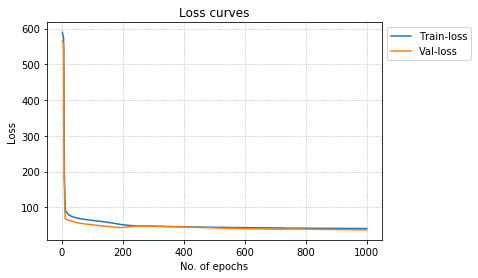

CPU times: user 21.2 s, sys: 670 ms, total: 21.8 s
Wall time: 21.3 s


In [7]:
%%time
train([X_train, y_train, X_test, y_test], batch_size, [w1, w2], n_epochs)